# Labs 5 & 6 

In this lab, we focus on predicting annual excess bond returns in the style of Bianchi, Buchner, and Tamoni (2021, RFS), building on the influential literature that began with Cochrane and Piazzesi (2005, AER). The economic motivation behind this exercise is to test whether bond excess returns—which are crucial for understanding fixed income performance—can be predicted using information embedded in yield curves and macroeconomic variables.

To achieve this, we implement two classes of forecasting models:
- Penalized Regression Methods:
We use LASSO, Ridge, and Elastic Net regressions that incorporate forward rates as predictors. These methods help manage potential overfitting and multicollinearity by applying different forms of regularization. The underlying idea is that forward rates, which are derived from the yield curve, contain valuable information about the term structure of interest rates and can be exploited to forecast excess bond returns.

- PCA-Based Methods:
We also apply Principal Components Regression (PCR) and Partial Least Squares (PLS) regression. Instead of using all macroeconomic variables directly, we first extract their principal components to capture the key common movements in the economy. These principal components serve as condensed representations of a wide range of macroeconomic indicators, thereby reducing dimensionality while retaining essential information. PCR and PLS then use these factors as predictors to forecast bond returns.

Forecast accuracy is evaluated using out-of-sample R2R2 values, along with additional significance tests (such as the RSZ p-values). These metrics provide insights into how much the models improve predictions compared to a naive historical mean benchmark, which is consistent with the expectations hypothesis.

In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install scipy
# %pip install statsmodels
# %pip install shap
# %pip install openpyxl


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit, ParameterGrid
import statsmodels.api as sm
from scipy.stats import t as tstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import shap
import warnings


# To display progress bars - displays a progress bar in the notebook
# if not in a notebook, tqdm will still work, but won't display the progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# To parallelize code
from joblib import Parallel, delayed

warnings.filterwarnings("ignore", category=UserWarning) # suppress warnings for cleaner output


/Users/2798523q/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will start by reading in the excel file containing the yield curve dataset. Annualized monthly yield values for different maturities in percentage units. 

In [3]:
# Read the Excel file into a DataFrame, skipping the first 8 rows so that the 9th row is used as header
df = pd.read_excel("yieldcurve_data/LW_monthly.xlsx", skiprows=8)

In [4]:
display(df.head(2))
print(df.shape)

,yyyymm,1 m,2 m,3 m,4 m,5 m,6 m,7 m,8 m,9 m,...,351 m,352 m,353 m,354 m,355 m,356 m,357 m,358 m,359 m,360 m
0,196106,2.092599,2.193762,2.289332,2.380383,2.468033,2.552678,2.633305,2.707428,2.771769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,196107,1.798512,1.965591,2.111735,2.240318,2.354286,2.455535,2.544454,2.620127,2.681560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(763, 361)


## Calculate Annual Excess Returns 

We will calculate annual excess returns for 2 and 5 year maturities. 

Following the notation of Bianchi, Buchner and Tamoni (2021, RFS), we consider a zero coupon bond with maturity $t+n$ and a payoff of one dollar. We denote its log price and continuously compounded yield at time $t$ by $p_t^{(n)}$ and $y_t^{(n)} = -\frac{1}{n}p_t^{(n)}$, respectively where the superscript $n$ refers to the bond's remaining maturity. The (log) excess return to the $n$-year bond from $t$ to $t+1$, when its remaining maturity is $n-1$, is denoted by $x r_{t+1}^{(n)}=p_{t+1}^{(n-1)}-p_t^{(n)}-y_t^{(1)}$. Then, it is possible to express the log returns to bonds as

$$
x r_{t+1}^{(n)}=-(n-1)\left(y_{t+1}^{(n-1)}-y_t^{(n)}\right)+\left(y_t^{(n)}-y_t^{(1)}\right) .
$$


**In this lab, we will use several supervised machine learning algorithms, to predict one year excess bond returns $xr_{t+1}^{(n)}$ using both forward rates and a set of macroeconomic variables**

$$
xr_{t+1} = g(x_t, F_t; \theta)
$$

where $g(.)$ is the ML model we use to map forward rates $x_t$ and macro variables or factors $F_t$ and the model's parameters are in $\theta$. 

Since we have monthly data, our excess returns specification needs to be shifted by 12 periods. Rewriting the excess returns specifications as 

$$
x r_{t+12}^{(n)}=-(n-1)\left(y_{t+12}^{(n-1)}-y_t^{(n)}\right)+\left(y_t^{(n)}-y_t^{(1)}\right)
$$

In [4]:
# Clean the column names by stripping extra spaces
df.columns = df.columns.str.strip()

# Define maturities for 2, 5 and 10 years in months
maturities = {'2_year': 24, '5_year': 60, '10_year': 120}

# Dictionary to hold computed excess return columns
excess_returns = {}

# Loop over each specified maturity
for label, n in maturities.items():
    col_n = f'{n} m'         # yield at maturity n (months) at time t
    col_n_minus = f'{n-1} m'   # yield at maturity n-1 (months)
    
    # Check that the required columns exist in the DataFrame
    if col_n in df.columns and col_n_minus in df.columns:
        # Compute excess returns using a 12-month shift for the forward yield of (n-1) maturity
        excess_returns[f'xr_{label}'] = -(n-1) * (df[col_n_minus].shift(-12) - df[col_n]) + (df[col_n] - df['1 m'])
    else:
        print(f"Columns for maturity {n} or {n-1} not found.")

# Create a DataFrame from the computed columns and concatenate it with the original DataFrame
excess_returns_df = pd.DataFrame(excess_returns, index=df.index)
df = pd.concat([df, excess_returns_df], axis=1)


In [5]:
df

,yyyymm,1 m,2 m,3 m,4 m,5 m,6 m,7 m,8 m,9 m,...,354 m,355 m,356 m,357 m,358 m,359 m,360 m,xr_2_year,xr_5_year,xr_10_year
0,196106,2.092599,2.193762,2.289332,2.380383,2.468033,2.552678,2.633305,2.707428,2.771769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.195482,0.188718,NaN
1,196107,1.798512,1.965591,2.111735,2.240318,2.354286,2.455535,2.544454,2.620127,2.681560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.287786,0.291605,NaN
2,196108,2.022547,2.163381,2.297206,2.424001,2.542289,2.649290,2.741553,2.816288,2.873426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.642927,14.104656,NaN
3,196109,1.976399,2.130537,2.277331,2.414313,2.536931,2.638611,2.713540,2.762042,2.792608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.604611,5.229736,NaN
4,196110,1.981141,2.129609,2.272949,2.407495,2.528128,2.628622,2.704765,2.758808,2.798653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.926450,5.796151,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,202408,5.183378,5.087267,4.992325,4.899715,4.810599,4.726013,4.646672,4.572866,4.504532,...,4.173293,4.171083,4.169283,4.167854,4.166737,4.165856,4.165131,NaN,NaN,NaN
759,202409,4.638721,4.580495,4.514536,4.443272,4.369423,4.295713,4.224433,4.157130,4.094602,...,4.118074,4.114081,4.110295,4.106661,4.103116,4.099591,4.096023,NaN,NaN,NaN
760,202410,4.501049,4.488369,4.468453,4.443663,4.416586,4.389511,4.363947,4.340479,4.319004,...,4.407622,4.404139,4.400747,4.397392,4.394017,4.390575,4.387027,NaN,NaN,NaN
761,202411,4.326863,4.332829,4.333859,4.331393,4.326811,4.321200,4.315176,4.308855,4.301971,...,4.299915,4.295449,4.291061,4.286713,4.282368,4.277993,4.273561,NaN,NaN,NaN


In [6]:
# Convert the 'yyyymm' column to a datetime object
df['date'] = pd.to_datetime(df['yyyymm'].astype(str), format='%Y%m')

### Excess Returns - Time Series plot

plot excess returns for 2, 5 and 10 year maturities. These will be our targets. 

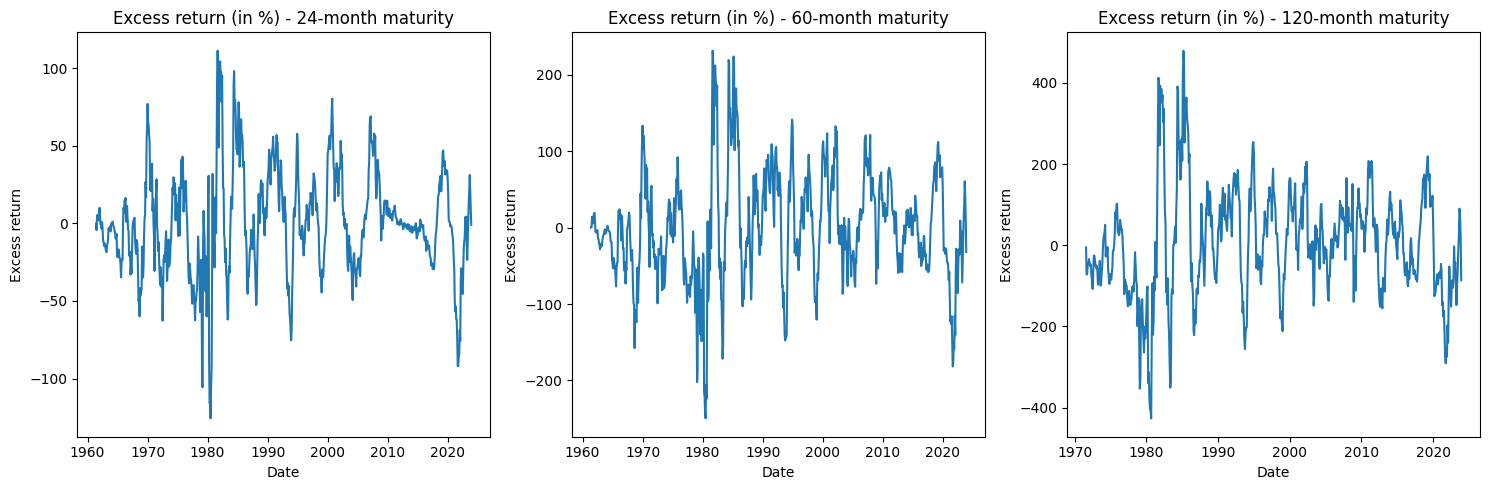

In [7]:
# plot all the excess returns targets in the same plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (label, n) in enumerate(maturities.items()):
    xr_label = f'xr_{label}'
    ax[i].plot(df['date'], df[xr_label])
    ax[i].set_title(f'Excess return (in %) - {n}-month maturity')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Excess return')
plt.tight_layout()
plt.show()

### Compute Forward Rates 

Forward Rates are our regressors. 

The loop computes the forward rate $f_t(n)=n y_t(n)-(n-1) y_t(n-1)$ for each $n$ from 2 to 360 and stores each result in the dictionary forward_dict using the key $f^{\prime}\{n\} m$ ' .

After the loop, a new DataFrame forward_df is created from the dictionary, and then it is concatenated with the original DataFrame df using pd.concat (axis=1). This approach avoids repeated in-place column insertions, which can lead to a highly fragmented DataFrame and performance warnings.

In [8]:
# -------------------------------
#  Compute forward rates (for maturities 2 to 360 months)
# -------------------------------
# The forward rate f_t(n) = n*y_t(n) - (n-1)*y_t(n-1)
# Create a dictionary to store forward rate columns
forward_dict = {}

# Loop over maturities 2 to 360 months to compute forward rates
for n in range(2, 361):
    col_n = f'{n} m'
    col_nm1 = f'{n-1} m'
    if col_n in df.columns and col_nm1 in df.columns:
        f_col = f'f_{n}m'
        forward_dict[f_col] = n * df[col_n] - (n-1) * df[col_nm1]

# Concatenate all computed forward rate columns
forward_df = pd.DataFrame(forward_dict)
df = pd.concat([df, forward_df], axis=1)


In [9]:
df 

,yyyymm,1 m,2 m,3 m,4 m,5 m,6 m,7 m,8 m,9 m,...,f_351m,f_352m,f_353m,f_354m,f_355m,f_356m,f_357m,f_358m,f_359m,f_360m
0,196106,2.092599,2.193762,2.289332,2.380383,2.468033,2.552678,2.633305,2.707428,2.771769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,196107,1.798512,1.965591,2.111735,2.240318,2.354286,2.455535,2.544454,2.620127,2.681560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,196108,2.022547,2.163381,2.297206,2.424001,2.542289,2.649290,2.741553,2.816288,2.873426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,196109,1.976399,2.130537,2.277331,2.414313,2.536931,2.638611,2.713540,2.762042,2.792608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,196110,1.981141,2.129609,2.272949,2.407495,2.528128,2.628622,2.704765,2.758808,2.798653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,202408,5.183378,5.087267,4.992325,4.899715,4.810599,4.726013,4.646672,4.572866,4.504532,...,2.876474,2.980547,3.104995,3.243872,3.388791,3.530250,3.659110,3.767767,3.850766,3.904864
759,202409,4.638721,4.580495,4.514536,4.443272,4.369423,4.295713,4.224433,4.157130,4.094602,...,2.397544,2.464140,2.541740,2.623376,2.700806,2.766095,2.812942,2.837403,2.837945,2.815049
760,202410,4.501049,4.488369,4.468453,4.443663,4.416586,4.389511,4.363947,4.340479,4.319004,...,2.953615,3.012640,3.073352,3.128468,3.171231,3.196773,3.202757,3.189295,3.158386,3.113224
761,202411,4.326863,4.332829,4.333859,4.331393,4.326811,4.321200,4.315176,4.308855,4.301971,...,2.542360,2.592273,2.640625,2.682656,2.714434,2.733443,2.738790,2.731012,2.711653,2.682775


## Penalized Regressions

We will implement three penalized regresssions:
- LASSO
- Ridge and 
- Elastic Net Regressions

Below code creates the target variables - excess returns of bonds with 2, 5 and 10 year maturities. 

In [10]:
# retrieve the forward rate column names from forward_dict
forward_cols = list(forward_dict.keys())

# Forecast target variables (excess returns for 2, 5, and 10-year)
targets = ['xr_2_year', 'xr_5_year', 'xr_10_year']

# Run a simple test on the targets to verify that they contain sensible values.
print("Target summary statistics:")
print(df[targets].describe())

Target summary statistics:
        xr_2_year   xr_5_year  xr_10_year
count  751.000000  751.000000  629.000000
mean     0.563376    1.283282    6.383561
std     33.617784   71.492641  132.993483
min   -125.649879 -249.624619 -426.220796
25%    -19.902403  -42.770639  -78.873019
50%     -0.590215   -3.469338    6.782156
75%     18.619928   45.587587   86.279982
max    111.355970  231.558138  479.297547


Now, we write two functions. The first computes the out of sample R-squared - the key statistic to evaluate our models predictive ability. The second function computes the associated p-values for hypothesis testing. 

The out-of-sample $R^2$ (denoted $R_{\text {oos }}^2$ ) tells us how much our model improves forecasting error relative to a simple benchmark-the in-sample historical mean forecast (the expectations hypothesis).

- Naive Forecast Calculation: The line `y_condmean = np.cumsum(y_true) / np.arange ( 1 , y_true.size +1 )` calculates the cumulative average of the actual values. By inserting a NaN at the beginning and shifting (np.insert(...) [:-1] ), we ensure that the forecast for a given time $t+1$ is based only on data up to time $t$. This gives us a "naive" or "conditional mean" forecast.
- Error Calculations: SSres is the sum of squared residuals from our model (i.e., the squared differences between the actual outcomes and our model's forecast). SStot is the sum of squared deviations of the actual outcomes from the naive forecast.

- Interpreting $R_{\text {oos }}^2$ : The formula $1-\frac{\text { SSres }}{\text { SStot }}$ indicates the fraction by which the model reduces forecasting error compared to the naive benchmark. ***A positive value means that our model improves on the naive forecast, whereas a negative value implies that the model performs worse than simply using the historical mean***.

In [11]:
# Functions to compute out of sample R-squared and Rapach, Strauss, and Zhou (2010) p-values 
def R2OOS(y_true, y_forecast):
    """
    Computes out-of-sample R^2 as:
    R^2_oos = 1 - (sum((y_true - y_forecast)^2)) / (sum((y_true - naive_forecast)^2))
    where naive_forecast is the in-sample historical mean forecast.
    """
    # Compute conditional mean forecast (naive forecast) from in-sample data
    y_condmean = np.cumsum(y_true) / np.arange(1, y_true.size + 1)
    y_condmean = np.insert(y_condmean, 0, np.nan)[:-1]
    y_condmean[np.isnan(y_forecast)] = np.nan

    SSres = np.nansum((y_true - y_forecast) ** 2)
    SStot = np.nansum((y_true - y_condmean) ** 2)
    return 1 - SSres / SStot

def RSZ_Signif(y_true, y_forecast):
    """
    Computes the significance measure (p-value) as in Rapach, Strauss, and Zhou (2010).
    """
    y_condmean = np.cumsum(y_true) / np.arange(1, y_true.size + 1)
    y_condmean = np.insert(y_condmean, 0, np.nan)[:-1]
    y_condmean[np.isnan(y_forecast)] = np.nan

    f = (y_true - y_condmean)**2 - (y_true - y_forecast)**2 + (y_condmean - y_forecast)**2
    x = np.ones(f.shape)
    model = sm.OLS(f, x, missing='drop', hasconst=True)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    return 1 - tstat.cdf(results.tvalues[0], results.nobs - 1)

The second function provides a p-value based on the method introduced by Rapach, Strauss, and Zhou (2010). It tests whether the improvement in forecasting error (relative to the naive forecast) is statistically significant.

The test statistic is calculated as:
$$
f=\left(y_{\text {true }}-y_{\text {condmean }}\right)^2-\left(y_{\text {true }}-y_{\text {forecast }}\right)^2+\left(y_{\text {condmean }}-y_{\text {forecast }}\right)^2 .
$$
This measure essentially captures how much better (or worse) our forecast is relative to the naive forecast, in squared-error terms.

The function runs a simple OLS regression of $f$ on a constant (i.e., it regresses $f$ on a column of ones). The regression uses robust (HAC) standard errors with a maximum lag of 12 to account for potential autocorrelation in the errors.

The test statistic (t-value) from this regression is then compared to a t-distribution to obtain a p-value. The resulting p-value tells us the probability of observing such an improvement (or worse) if the model forecast were no better than the naive forecast. A lower p-value indicates that the model's improvement over the naive benchmark is statistically significant.

### Function to tune Hyperparameters

This function is designed to "tune" or select the best hyperparameters for a regression model using a validation set. In our forecasting context, we want to choose the best level of regularization (and, for ElasticNet, the best mix between L1 and L2 penalties) so that the model minimizes the mean squared error (MSE) on a holdout validation sample. 

Theese are the arguments that the function takes:
`model_type`:
A string indicating which model to tune – "ElasticNet", "Lasso", or "Ridge".

`X_train_part`, `y_train_part`:
These represent a portion of the training data (typically an 85% subset) used for fitting the model during tuning.

`X_val`, `y_val`:
This is the validation set (the remaining 15% of the training data) used to evaluate model performance (MSE).

`alphas`:
A list of candidate regularization parameters (strength of penalty) to test.

`l1_ratios`:
(Only for ElasticNet) A list of candidate mixing ratios between L1 (lasso) and L2 (ridge) penalties.

In [13]:
# Define a simple tuning routine (with option for parallel grid search)
def tune_model(model_type, X_train_part, y_train_part, X_val, y_val, alphas, l1_ratios=None):
    best_val_mse = np.inf
    best_params = None
    if model_type == 'ElasticNet':
        X_combined = np.vstack([X_train_part, X_val])
        y_combined = np.concatenate([y_train_part, y_val])
        test_fold = np.concatenate((np.full(X_train_part.shape[0], -1),
                                    np.zeros(X_val.shape[0])))
        ps = PredefinedSplit(test_fold)
        grid = list(ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios}))
        
        def evaluate_param(params):
            model = ElasticNetCV(cv=ps, l1_ratio=[params['l1_ratio']],
                                 alphas=[params['alpha']], max_iter=50000,
                                 random_state=42)
            model.fit(X_combined, y_combined)
            mse = mean_squared_error(y_val, model.predict(X_val))
            return mse, params

        results = Parallel(n_jobs=-1)(delayed(evaluate_param)(params) for params in grid)
        for mse, params in results:
            if mse < best_val_mse:
                best_val_mse = mse
                best_params = params
    else:
        for alpha in alphas:
            if model_type == 'Lasso':
                model = Lasso(alpha=alpha, max_iter=50000)
            elif model_type == 'Ridge':
                model = Ridge(alpha=alpha, max_iter=50000)
            model.fit(X_train_part, y_train_part)
            mse = mean_squared_error(y_val, model.predict(X_val))
            if mse < best_val_mse:
                best_val_mse = mse
                best_params = {'alpha': alpha}
    return best_params

Initialization:
The above function begins by setting best_val_mse to infinity and best_params to None. These variables will keep track of the best (lowest) MSE and the corresponding hyperparameter settings.

Handling ElasticNet:When model_type is "ElasticNet", the function does the following:
- Combine Training and Validation Sets: It vertically stacks X_train_part and X_val and concatenates y_train_part and y_val into one combined dataset. This is needed because ElasticNetCV in scikit-learn allows you to supply a custom cross-validation split.
- Define a PredefinedSplit: A test_fold array is created where all observations from X_train_part are marked with -1 (used as training) and all observations from X_val are marked with 0 (used as the validation fold). This tells ElasticNetCV which data points belong to training versus validation.
- Grid of Parameters: The function creates a grid (using ParameterGrid) over the provided alphas and l1_ratios.
- Evaluation Function:It defines an inner function, evaluate_param(params), which Instantiates an ElasticNetCV model with the current candidate parameters (alpha and l1_ratio), sets a high iteration limit (max_iter=50000) for convergence, and a fixed random state for reproducibility. Then, it Fits the model on the combined data. Computes the MSE on the validation set (using only X_val and y_val) and Returns the MSE and the current parameter set.
- Parallel Evaluation: Using library `joblib`’s Parallel with n_jobs=-1 (to use all available cores), the function evaluates each candidate in the parameter grid concurrently.
- It then loops over the results and selects the parameter set that achieved the lowest validation MSE.

Handling Lasso and Ridge: For these models, the function:
- Loops over the candidate alphas.
- For each alpha:
    - Instantiates either a Lasso or Ridge model (depending on model_type), again with a high iteration limit.
    - Fits the model on the X_train_part and y_train_part.
    - Computes the validation MSE using X_val and y_val.
    - Updates best_val_mse and best_params whenever a lower MSE is found.


After evaluating all candidate parameters, the function returns best_params, which contains the optimal hyperparameters (either just {'alpha': best_value} for Lasso/Ridge, or {'alpha': best_value, 'l1_ratio': best_value} for ElasticNet).

### Training, Validation and Testing - Forward Rates 

We follow the ML literature on stock return predictability and bond return predictability by using a recursive expanding window forecasting approach. In our recursive expanding window forecasting approach, we update our model with all available historical data up to a given forecast date, then use that model to predict the next period’s excess bond return. At each forecast origin (starting from January 1990), the data before that date is split into an estimation and a validation set to tune hyperparameters; the best-performing model is then refitted on the entire training set and used to generate a one-period-ahead forecast. This process is repeated, with the training window expanding over time, which simulates a real-time forecasting scenario where new information is continually incorporated to update predictions. 

Here's a brief summary of what's happening in the below code:

- Forecast Setup and Data Preparation: The code sets the forecast start date (January 1990) and then identifies all rows in the main DataFrame (df) with dates on or after this date. These indices mark the points at which forecasts will be generated. Dictionaries are created to store forecasts (results), naive forecasts (historical means) (naive_forecasts), and actual outcomes (actuals) for each target (the 3 different maturities) and each model type (Lasso, Ridge, ElasticNet).


- Hyperparameter Grid: The code specifies a list of candidate alphas and, for ElasticNet, candidate l1_ratios. It also sets a minimum training sample size and a tune_interval (every 5 iterations) to control how often hyperparameters are re-tuned. A dictionary (tuned_params) is used to store the best parameters found for each model and target combination.

- Expanding Window Forecast Loop: The loop iterates over each forecast index using a progress bar (`tqdm` library is used here). For each forecast origin, the data before that point is used as the training sample (after dropping rows with missing values). The training sample is further split into two parts: one for tuning the hyperparameters (about 85% of the training data) and a validation set (the remaining 15%). Predictors (here, the forward rates) are standardized using StandardScaler so that all features contribute equally.
For each target, a naive forecast is computed as the historical mean of the training target values.

- Tuning and Forecasting: For each model (Lasso, Ridge, ElasticNet), if it’s time to retune (or if no previous tuning exists for that target), the tune_model function is called to determine the best hyperparameters based on validation MSE. The selected parameters are stored for later use. Using the tuned parameters, the appropriate model is instantiated (with a high iteration limit to ensure convergence) and fitted on the entire standardized training set. A forecast is then made for the current test observation and stored.

- Performance Metrics: After the forecasting loop, the code computes the out-of-sample R-squared and the RSZ significance p-values for each target and model. It carefully handles missing values by filtering out any NaNs and checks for division-by-zero when computing the R-squared. The final performance metrics are printed, allowing us to assess how much each model improves forecast accuracy over a naive benchmark.


**NOTE: The code takes around 10-12 mins to execute for this parameterization! Progress bars are created to track the execution progress.**

In [14]:
# Setup progress bar for the forecast loop
forecast_start = pd.Timestamp('1990-01-01')
forecast_idx = df.index[df['date'] >= forecast_start].tolist()
model_names = ['Lasso', 'Ridge', 'ElasticNet']

# Containers for forecasts and actuals
results = {target: {model: [] for model in model_names} for target in targets}
naive_forecasts = {target: [] for target in targets}
actuals = {target: [] for target in targets}

# Updated hyperparameter grid (possibly narrower)
alphas = [0.1, 1, 10, 50]
l1_ratios = [0.1, 0.5, 0.9]

min_train_size = 100
tune_interval = 5  # tune hyperparameters every 5 iterations
tuned_params = {model: {} for model in model_names}  # store last tuned parameters

# Outer forecast loop with progress tracking
for i in tqdm(forecast_idx, desc="Forecasting iterations"):
    if i < min_train_size:
        continue

    # Define training sample: all observations before forecast origin i
    train_df = df.iloc[:i].dropna(subset=targets + forward_cols)
    test_df = df.iloc[[i]]
    if len(train_df) < min_train_size:
        continue

    n_train = len(train_df)
    split_idx = int(0.85 * n_train)
    train_part = train_df.iloc[:split_idx]
    val_part = train_df.iloc[split_idx:]
    
    # Extract predictors (forward rates) and standardize them
    X_train = train_df[forward_cols].values
    X_test = test_df[forward_cols].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_part = scaler.transform(train_part[forward_cols].values)
    X_val = scaler.transform(val_part[forward_cols].values)
    
    for target in targets:
        y_train = train_df[target].values
        y_test = test_df[target].values
        
        # Naive forecast: historical mean of training sample
        naive_forecast = np.mean(y_train)
        naive_forecasts[target].append(naive_forecast)
        actuals[target].append(y_test[0])
        
        # Tuning: only re-tune every 'tune_interval' iterations
        for m_name in model_names:
            if (i % tune_interval == 0) or (m_name not in tuned_params or tuned_params[m_name].get(target) is None):
                if m_name == 'ElasticNet':
                    best_params = tune_model('ElasticNet', X_train_part, train_part[target].values,
                                               X_val, val_part[target].values, alphas, l1_ratios)
                else:
                    best_params = tune_model(m_name, X_train_part, train_part[target].values,
                                             X_val, val_part[target].values, alphas)
                tuned_params[m_name][target] = best_params

        # Forecast with each model using the stored tuned parameters
        for m_name in model_names:
            if m_name == 'ElasticNet':
                params = tuned_params[m_name][target]
                model_final = ElasticNet(alpha=params['alpha'],
                                         l1_ratio=params['l1_ratio'],
                                         max_iter=50000, random_state=42)
            elif m_name == 'Lasso':
                params = tuned_params[m_name][target]
                model_final = Lasso(alpha=params['alpha'], max_iter=50000)
            elif m_name == 'Ridge':
                params = tuned_params[m_name][target]
                model_final = Ridge(alpha=params['alpha'], max_iter=50000)
            model_final.fit(X_train_scaled, y_train)
            forecast = model_final.predict(X_test_scaled)[0]
            results[target][m_name].append(forecast)

# -------------------------------
# Compute Out-of-Sample Performance Metrics Robustly
# -------------------------------
oos_r2 = {}
rsz_pval = {}

for target in targets:
    oos_r2[target] = {}
    rsz_pval[target] = {}
    actual = np.array(actuals[target])
    naive = np.array(naive_forecasts[target])
    for m_name in model_names:
        forecasts = np.array(results[target][m_name])
        # Only use indices where actual, forecast, and naive are not NaN
        valid = ~np.isnan(actual) & ~np.isnan(forecasts) & ~np.isnan(naive)
        if np.sum(valid) == 0:
            computed_r2 = np.nan
        else:
            num = np.sum((actual[valid] - forecasts[valid]) ** 2)
            den = np.sum((actual[valid] - naive[valid]) ** 2)
            if den == 0:
                computed_r2 = np.nan
            else:
                computed_r2 = 1 - num / den
        oos_r2[target][m_name] = computed_r2
        
        # Compute RSZ significance only if valid data exists
        if np.sum(valid) == 0:
            computed_rsz = np.nan
        else:
            computed_rsz = RSZ_Signif(actual[valid], forecasts[valid])
        rsz_pval[target][m_name] = computed_rsz

print("Out-of-Sample R-squared and RSZ p-values:")
for target in oos_r2:
    print(f"\nTarget: {target}")
    for m_name in model_names:
        print(f"  {m_name}: R2_oos = {oos_r2[target][m_name]:.4f}, RSZ p-val = {rsz_pval[target][m_name]:.4f}")


Forecasting iterations:   0%|          | 0/420 [00:00<?, ?it/s]

Out-of-Sample R-squared and RSZ p-values:

Target: xr_2_year
  Lasso: R2_oos = 0.0074, RSZ p-val = 0.0256
  Ridge: R2_oos = 0.0589, RSZ p-val = 0.0051
  ElasticNet: R2_oos = 0.1954, RSZ p-val = 0.0026

Target: xr_5_year
  Lasso: R2_oos = 0.1057, RSZ p-val = 0.0034
  Ridge: R2_oos = 0.1019, RSZ p-val = 0.0006
  ElasticNet: R2_oos = 0.0386, RSZ p-val = 0.0006

Target: xr_10_year
  Lasso: R2_oos = 0.0164, RSZ p-val = 0.0187
  Ridge: R2_oos = 0.0726, RSZ p-val = 0.0004
  ElasticNet: R2_oos = -0.0149, RSZ p-val = 0.0005


The R-squared is a unit free measure. To interpret $R^2_{OOS}$​ of, say, 0.1057 means that your forecasting model reduces the mean squared error by 10.57% relative to a benchmark (here, the naive historical mean forecast). If the $R^2_{OOS}$​ ​ is negative, it indicates that your model’s forecasts are worse than the naive benchmark. The benchmark is the naive historical mean. 

The $R^2_{OOS}$​ ​lies in the range $(-\infty, 1]$. 

The naive benchmark here is essentially what you’d expect under the expectations hypothesis, which implies that bond excess returns are unpredictable (or equal to their historical mean).

Economically, these results suggest that the ML models are capturing some predictive signals in the forward rates that the expectations hypothesis (or unconditional mean forecast) misses. For instance, an out‐of‐sample R-squared of 0.1954 for the 2‑year horizon with ElasticNet means that this model reduces the forecast error by roughly 19.5% relative to the naive expectations hypothesis. This indicates that, at least for shorter maturities, there is meaningful information in the data that ML models can exploit to predict annual bond excess returns.

In contrast, for longer maturities (like the 10‑year), only the Ridge model provides a modest improvement (around 7%), while ElasticNet even underperforms relative to the naive benchmark. This might imply that the predictability of excess returns diminishes with maturity, or that different regularisation schemes (or model structures) are needed for longer horizons.

The reported p-values test for the null hypothesis $H_0: R^2_{OOS} \leq 0$. Values smaller than a threshold such as (0.05) indicate rejection of this null hypothesis and statistical significance of our forecast. Statistical significance does not necessarily imply economic gains (the magnitude of implied returns needs to be calculated to find this). 


Comments on the Computational Complexity: This code has been written with performance in mind. 

Parallelization in Tuning:
- We use `joblib.Parallel` along with delayed to evaluate hyperparameter combinations in parallel for the ElasticNet case. **joblib's parallelization works on any computer that supports multiple cores—it doesn't require a high-performance computing (HPC) cluster. When you set n_jobs=-1, joblib will try to use all available cores on your machine**.
- The outer forecast loop is wrapped with `tqdm`, which prints a progress bar showing the number of iterations completed.
- Tuning Frequency: The variable `tune_interval` controls how often you re-run the grid search (here, every 5 iterations). In between, the last tuned parameters for each target and model are reused, saving computation time.

You can adjust the grid size, tune_interval, and number of parallel jobs as needed to strike a balance between speed and performance. 

## Using Macro Variables

We will now use macro predictors to see if macroeconomic variables have more predictive power than the forward rates we analysed above. We will be using the set of over 130 monthly macro predictors constructed by McCracken and Ng (2015). 

These are time series variables. To make these time series variables stationary, we apply transformations that's recommended by McCracken and Ng (2015). The transformation codes are given in the second row in the csv file. The function below applies the transformation to each series. Some transformations like code 2 take the first differences while some like 5 take first differences in logs. All transformations are coded to make the resultant series stationary. 

In [15]:
# Define a helper function for the transformations
def apply_transformation(series, code):
    """
    Apply a transformation to a pandas Series according to the code:
    (1) no transformation;
    (2) Δx_t;
    (3) Δ²x_t;
    (4) log(x_t);
    (5) Δ log(x_t);
    (6) Δ² log(x_t);
    (7) Δ(x_t/x_{t-1} - 1.0)
    """
    if code == 1:
        return series
    elif code == 2:
        return series.diff()
    elif code == 3:
        return series.diff(2)
    elif code == 4:
        return np.log(series)
    elif code == 5:
        return np.log(series).diff()
    elif code == 6:
        return np.log(series).diff(2)
    elif code == 7:
        return series.pct_change().diff()
    else:
        raise ValueError(f"Unknown transformation code: {code}")

In [16]:
# Read the transformation row (skip header, then read 1 row)
transformation_row = pd.read_csv('fred_md/fredmd_2025_01.csv', skiprows=1, nrows=1, header=None)

# The first cell in the transformation row is a label ("Transform:"); the remaining cells are the codes.
# Convert these codes to integers.
transformation_codes = transformation_row.iloc[0, 1:].astype(int).values
print("Transformation codes:", transformation_codes)

Transformation codes: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 5 5 2 2 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 1 2 1 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 2 6 6 5 6 6 7 6 6 6 2 5
 2 5 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 2 6 6 6 1]


now, read in all the macro variables from the dataset. We rename the date column `sasdate` to `date` to be consistent with our yields dataframe `df`. 

In [17]:
# Skip the first two rows (header + transformation row)
fred_df = pd.read_csv('fred_md/fredmd_2025_01.csv',  header=0)

# remove first row - the transformation codes row 
fred_df = fred_df.iloc[1:]
fred_df.head(2)

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN


In [18]:
# Process the date column ---
# the date column is named 'sasdate' and is in format month/day/year
fred_df['sasdate'] = pd.to_datetime(fred_df['sasdate'], format='%m/%d/%Y')

# If you wish to rename the date column to match your yield curve df's date column, e.g., "date":
fred_df.rename(columns={'sasdate': 'date'}, inplace=True)

### Apply Transformations

Now, we use the function we built `apply_transformation()` to transform each series in our dataframe. 

In [19]:
# Create a mapping from column name to transformation code for all columns except the date column.
macro_cols = list(fred_df.columns)
macro_cols.remove('date')  # leave the date column as is
transformation_map = dict(zip(macro_cols, transformation_codes))

# Apply the transformation for each macro variable column
for col in macro_cols:
    code = transformation_map[col]
    fred_df[col] = apply_transformation(fred_df[col], code)

print(fred_df.head())

        date       RPI   W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
1 1959-01-01       NaN       NaN              NaN        NaN       NaN   
2 1959-02-01  0.003877  0.003621         0.010349   0.007336  0.007310   
3 1959-03-01  0.006457  0.007325         0.009404  -0.003374  0.008321   
4 1959-04-01  0.006510  0.007029        -0.003622   0.019915  0.000616   
5 1959-05-01  0.005796  0.006618         0.012043   0.006839  0.007803   

     INDPRO   IPFPNSS   IPFINAL   IPCONGD  ...  DNDGRG3M086SBEA  \
1       NaN       NaN       NaN       NaN  ...              NaN   
2  0.019395  0.013405  0.008628  0.007309  ...              NaN   
3  0.014300  0.006036  0.004896  0.000000  ...        -0.000273   
4  0.021080  0.014339  0.014545  0.015652  ...        -0.000109   
5  0.014954  0.008267  0.009580  0.004766  ...        -0.000492   

   DSERRG3M086SBEA  CES0600000008  CES2000000008  CES3000000008  UMCSENTx  \
1              NaN            NaN            NaN            NaN       NaN  

## Principal Components Regression and Partial Least Squares Regression

We will get principal components from these macro variables dataset and use these to run Principal Components Regression and Partial Least Squares regressions. 

We will start by estimating 8 principal components from the macro dataset, this is the number recommended by McCracken and Ng (2015) who found 8 components to capture most of the variation in the 130 odd macroeconomic variables. 

Variables need to be standardized before principal components can be obtained, the below code does this and obtains 8 principal components and then merges this PCs dataframe with our yields dataframe from before. One thing to note in the below code is that, PCA cannot handle missing values so we replace missing values with the column mean and then proceeed with estimation.  

In [20]:
# Select macro columns (all except the date)
macro_cols = [col for col in fred_df.columns if col != 'date']

# Impute missing values in the macro dataset
imputer = SimpleImputer(strategy='mean')
macro_imputed = imputer.fit_transform(fred_df[macro_cols])

# Standardize the macro variables
scaler_macro = StandardScaler()
macro_scaled = scaler_macro.fit_transform(macro_imputed)

# Perform PCA to extract 8 principal components
pca = PCA(n_components=8)
macro_pcs = pca.fit_transform(macro_scaled)
# also get loadings - will be useful for interpreting the principal components
loadings = pca.components_.T  # shape (n_features, 8)
loadings_df = pd.DataFrame(loadings, index=macro_cols, columns=[f'PC{i+1}' for i in range(8)])

# Create a new DataFrame with the principal components
pcs_columns = [f'PC{i+1}' for i in range(8)]
fred_pcs_df = pd.DataFrame(macro_pcs, columns=pcs_columns)
fred_pcs_df['date'] = fred_df['date'].values

now merge this PCs dataframe with the bond yields dataframe from before. 

In [21]:
# Merge the principal components with the yields and excess returns dataframe 'df'
# (Assumes both dataframes have a column named 'date')
df_merged = pd.merge(df, fred_pcs_df, on='date', how='left')

# Optional: inspect the first few rows of the merged dataframe
print(df_merged.head())

   yyyymm       1 m       2 m       3 m       4 m       5 m       6 m  \
0  196106  2.092599  2.193762  2.289332  2.380383  2.468033  2.552678   
1  196107  1.798512  1.965591  2.111735  2.240318  2.354286  2.455535   
2  196108  2.022547  2.163381  2.297206  2.424001  2.542289  2.649290   
3  196109  1.976399  2.130537  2.277331  2.414313  2.536931  2.638611   
4  196110  1.981141  2.129609  2.272949  2.407495  2.528128  2.628622   

        7 m       8 m       9 m  ...  f_359m  f_360m       PC1       PC2  \
0  2.633305  2.707428  2.771769  ...     NaN     NaN  2.389653 -4.364974   
1  2.544454  2.620127  2.681560  ...     NaN     NaN  0.378029 -3.696034   
2  2.741553  2.816288  2.873426  ...     NaN     NaN  2.831569 -3.622161   
3  2.713540  2.762042  2.792608  ...     NaN     NaN -2.469016 -1.943057   
4  2.704765  2.758808  2.798653  ...     NaN     NaN  3.052315 -4.715691   

        PC3       PC4       PC5       PC6       PC7       PC8  
0  0.590041  1.316715 -0.376436 -2.41031

## Training, Validation and Testing - Macro Factors 

We will fit and predict Principal Components Regression and Partial Least Squares in a similar fashion as the penalized regressions we did before. 

The below code implements a recursive expanding window forecasting procedure using precomputed principal components as predictors to forecast annual excess bond returns for three targets (2-year, 5-year, and 10-year). For each forecast origin (starting from January 1990) in the merged dataset, the code selects all observations before that date as the training set and reserves the current observation for testing. The training set is standardized and then used to fit two types of models: PCR, which is simply an OLS regression on the eight standardized principal components, and PLS regression with the number of components fixed at eight. For each target, the naive forecast (the historical mean of the target in the training set) is calculated as a benchmark. Additionally, SHAP values are computed for both models to provide interpretability regarding which predictors (PCs) drive the forecasts.


After forecasting, the code evaluates performance using out-of-sample R-squared and RSZ p-values, which compare the models' forecast errors to those from the naive benchmark. The out-of-sample R-squared is computed by taking one minus the ratio of the sum of squared errors from the model forecasts to that from the naive forecasts, while the RSZ p-values assess the statistical significance of the improvement. Results for each target and model type (PCR and PLS) are then printed along with the corresponding SHAP values from the last forecast iteration, offering both quantitative measures of forecast performance and insights into the feature importance driving the predictions.


What are SHAP values?
- The SHAP (SHapley Additive exPlanations) value for a feature represents its average marginal contribution across all possible subsets of features. 
- SHAP values decompose the difference between the model’s output for a specific prediction and the average model output into contributions attributable to each feature. 
- For our forecasting exercise, SHAP values help explain which factors drive the predicted excess bond returns
In short, SHAP values help us in **measuring which features are important**. 

Note: Here are only using the 8 principal components obtained from the macro data as predictors (doesnt include the forward rates). 


In [22]:
# use only the precomputed 8 principal components as predictors
predictor_cols = [f'PC{i+1}' for i in range(8)]
targets = ['xr_2_year', 'xr_5_year', 'xr_10_year']

# Set forecast start date and get forecast indices from merged dataframe df_merged
forecast_start = pd.Timestamp('1990-01-01')
forecast_idx = df_merged.index[df_merged['date'] >= forecast_start].tolist()

# Containers for storing forecasts and actual outcomes.
results = {target: {'PCR': [], 'PLS': []} for target in targets}
naive_forecasts = {target: [] for target in targets}
actuals = {target: [] for target in targets}

# Containers for storing SHAP values (from the last forecast iteration for each target/model).
shap_values_dict = {target: {'PCR': None, 'PLS': None} for target in targets}

# Fix the number of components to 8 for both PCR and PLS.
n_components_fixed = 8

# Minimum training size
min_train_size = 100

# --- Forecasting Loop with Progress Tracking ---
for i in tqdm(forecast_idx, desc="Forecasting (PCR & PLS)"):
    if i < min_train_size:
        continue

    # Define training sample: all observations before forecast origin i
    train_df = df_merged.iloc[:i].dropna(subset=targets + predictor_cols)
    test_df = df_merged.iloc[[i]]
    if len(train_df) < min_train_size:
        continue

    # Extract predictors (the 8 PCs) and standardize.
    X_train = train_df[predictor_cols].values
    X_test = test_df[predictor_cols].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for target in targets:
        y_train = train_df[target].values
        y_test = test_df[target].values
        
        # Naive forecast: historical mean of y_train.
        naive_forecast = np.mean(y_train)
        naive_forecasts[target].append(naive_forecast)
        actuals[target].append(y_test[0])
        
        # ----- PCR: OLS regression using the 8 PC scores -----
        # Since the PCs are precomputed and fixed, we simply run an OLS.
        pcr_model = LinearRegression()
        pcr_model.fit(X_train_scaled, y_train)
        forecast_pcr = pcr_model.predict(X_test_scaled)[0]
        results[target]['PCR'].append(forecast_pcr)
        
        # Compute SHAP values for PCR.
        explainer_pcr = shap.Explainer(pcr_model.predict, X_train_scaled, feature_names=predictor_cols)
        shap_values_pcr = explainer_pcr(X_test_scaled)
        shap_values_dict[target]['PCR'] = shap_values_pcr.values
        
        # ----- PLS Regression with fixed n_components=8 -----
        pls_model = PLSRegression(n_components=n_components_fixed)
        pls_model.fit(X_train_scaled, y_train)
        # Adjust prediction indexing: pls.predict returns a 1-D array.
        forecast_pls = pls_model.predict(X_test_scaled)[0]
        # If forecast_pls is a 1-D array, use the first element.
        if isinstance(forecast_pls, np.ndarray) and forecast_pls.ndim > 0:
            forecast_pls = forecast_pls[0]
        results[target]['PLS'].append(forecast_pls)
        
        # Compute SHAP values for PLS.
        explainer_pls = shap.Explainer(pls_model.predict, X_train_scaled, feature_names=predictor_cols)
        shap_values_pls = explainer_pls(X_test_scaled)
        shap_values_dict[target]['PLS'] = shap_values_pls.values

# --- Performance Evaluation ---
oos_r2 = {}
rsz_pval = {}
for target in targets:
    oos_r2[target] = {}
    rsz_pval[target] = {}
    actual = np.array(actuals[target])
    naive = np.array(naive_forecasts[target])
    for model in ['PCR', 'PLS']:
        forecasts = np.array(results[target][model])
        valid = ~np.isnan(actual) & ~np.isnan(forecasts) & ~np.isnan(naive)
        if np.sum(valid) == 0:
            computed_r2 = np.nan
        else:
            num = np.sum((actual[valid] - forecasts[valid]) ** 2)
            den = np.sum((actual[valid] - naive[valid]) ** 2)
            computed_r2 = 1 - num / den if den != 0 else np.nan
        oos_r2[target][model] = computed_r2
        
        if np.sum(valid) > 0:
            computed_rsz = RSZ_Signif(actual[valid], forecasts[valid])
        else:
            computed_rsz = np.nan
        rsz_pval[target][model] = computed_rsz

print("Out-of-Sample R-squared and RSZ p-values for PCR and PLS:")
for target in oos_r2:
    print(f"\nTarget: {target}")
    for model in ['PCR', 'PLS']:
        print(f"  {model}: R2_oos = {oos_r2[target][model]:.4f}, RSZ p-val = {rsz_pval[target][model]:.4f}")

# --- Display SHAP values (for the last forecast iteration) ---
for target in targets:
    print(f"\nSHAP values for target {target}:")
    for model in ['PCR', 'PLS']:
        print(f"  {model} SHAP values: {shap_values_dict[target][model]}")


Forecasting (PCR & PLS):   0%|          | 0/420 [00:00<?, ?it/s]

Out-of-Sample R-squared and RSZ p-values for PCR and PLS:

Target: xr_2_year
  PCR: R2_oos = -0.4335, RSZ p-val = 0.0483
  PLS: R2_oos = -0.4335, RSZ p-val = 0.0483

Target: xr_5_year
  PCR: R2_oos = -0.3202, RSZ p-val = 0.1960
  PLS: R2_oos = -0.3202, RSZ p-val = 0.1960

Target: xr_10_year
  PCR: R2_oos = -0.2521, RSZ p-val = 0.0738
  PLS: R2_oos = -0.2521, RSZ p-val = 0.0738

SHAP values for target xr_2_year:
  PCR SHAP values: [[-1.5428836  -0.27549494  0.01047545 -0.0053839   0.01453994  0.93535201
   0.72057261 -0.17325809]]
  PLS SHAP values: [[-1.5428836  -0.27549494  0.01047545 -0.0053839   0.01453994  0.93535201
   0.72057261 -0.17325809]]

SHAP values for target xr_5_year:
  PCR SHAP values: [[-2.44247347 -1.47309849  0.0167903  -0.0146069   0.00458642  2.62124555
  -1.10633972  0.04803526]]
  PLS SHAP values: [[-2.44247347 -1.47309849  0.0167903  -0.0146069   0.00458642  2.62124555
  -1.10633972  0.04803526]]

SHAP values for target xr_10_year:
  PCR SHAP values: [[-3.633054

The negative out‐of‐sample R-squared values indicate that, for each target—whether for 2‑year, 5‑year, or 10‑year excess bond returns—the forecasting models (both PCR and PLS) perform worse than the simple benchmark of the historical mean. In other words, the model forecasts yield larger mean squared errors than if we had simply predicted the average of past returns. This is a clear sign that, under the current specifications, these models do not capture useful predictive information for bond excess returns, or the data and modeling choices do not lead to improvements over a naive forecast.

Additionally, the RSZ p-values offer insight into the statistical significance of these forecast differences. For the 2‑year target, the RSZ p-value of approximately 0.0483 suggests that the negative performance is statistically significant at the 5% level, meaning the model's underperformance is unlikely to be due to random chance. However, for the 5‑year target (p-value ≈ 0.1960) and the 10‑year target (p-value ≈ 0.0738), the p-values are higher, indicating that the evidence against the naive benchmark is weaker or only borderline significant. 

The nearly identical results between PCR and PLS are expected given that both methods use the same fixed set of 8 principal components as predictors in this analysis.

How do these results compare with the penalized regressions that use the forward rates?

The penalized regressions using forward rates yield modest to substantial improvements over the naive forecast—ElasticNet achieves a high R-squared of 19.54% for the 2‑year target, while Ridge and Lasso perform moderately well across different maturities, with improvements ranging from about 1.6% to 10.6%. In contrast, the PCA-based methods using macro principal components produce negative R-squared values across all horizons, indicating that forecasts based solely on these macro factors are worse than the naive benchmark. 

**Overall, these results suggest that forward rates carry more predictive power for excess bond returns than the aggregated macroeconomic information captured by the PCs in this analysis**.

lets plot feature importance using shap values. 

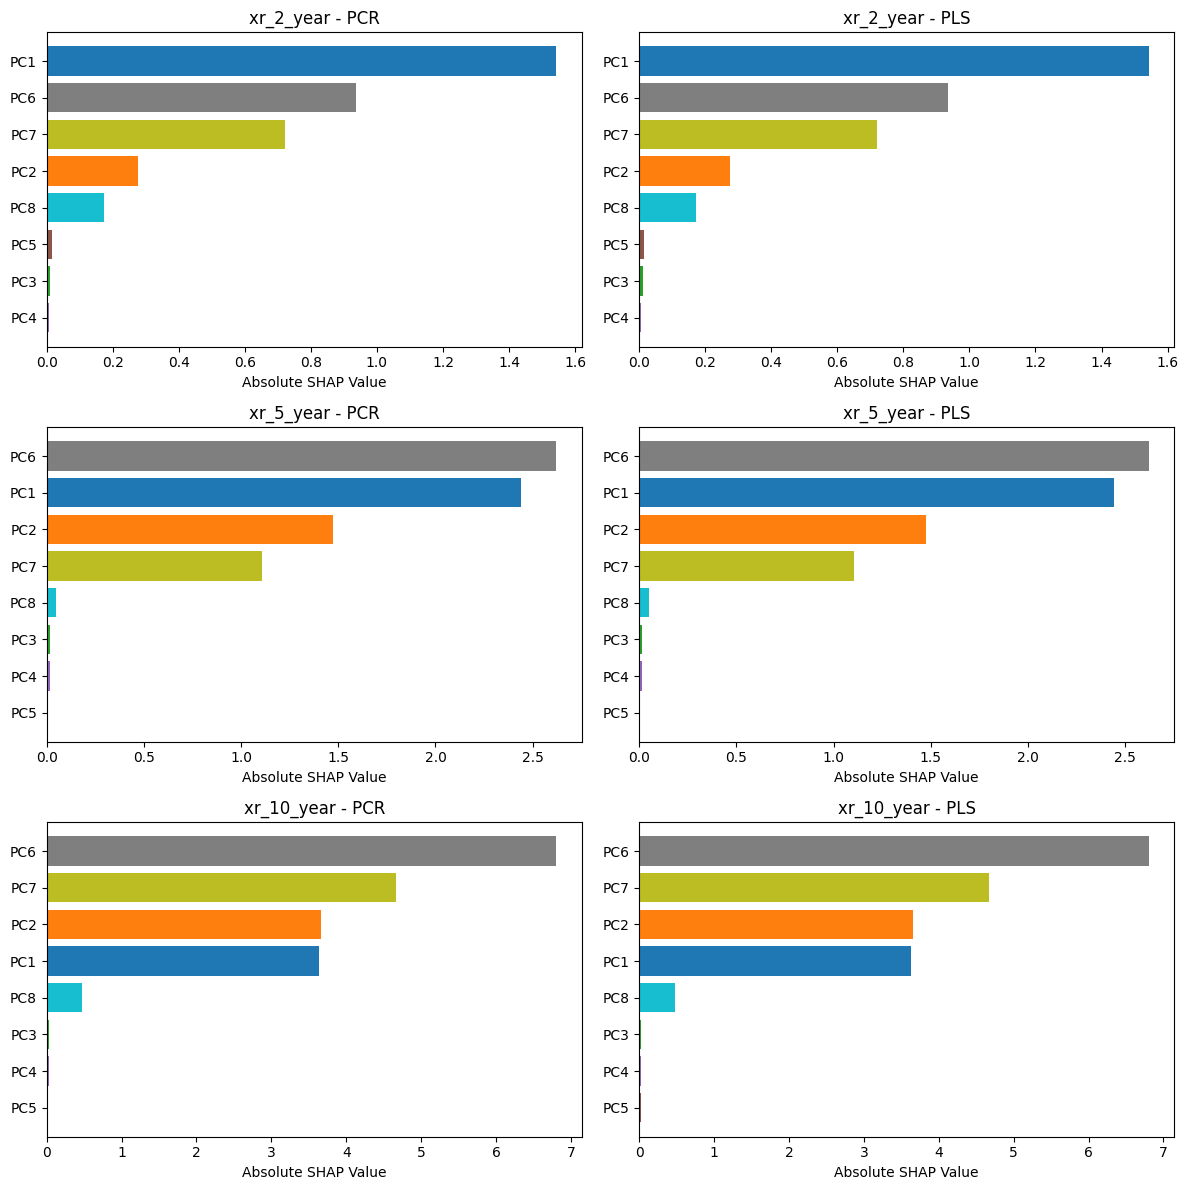

In [23]:
# Create a 3x2 grid of subplots.
fig, axs = plt.subplots(nrows=len(targets), ncols=2, figsize=(12, 12))

models = ['PCR', 'PLS']

for r, target in enumerate(targets):
    for c, model in enumerate(models):
        # Flatten the SHAP values into a 1D array
        shap_vals = np.ravel(shap_values_dict[target][model])
        abs_shap_vals = np.abs(shap_vals)
        # Get indices to sort the SHAP values in descending order
        sorted_idx = np.argsort(abs_shap_vals)[::-1]
        sorted_shap_vals = abs_shap_vals[sorted_idx]
        sorted_predictors = [predictor_cols[i] for i in sorted_idx]
        # Create a colormap with as many colors as predictors
        colors = plt.cm.tab10(np.linspace(0, 1, len(predictor_cols)))
        sorted_colors = colors[sorted_idx]
        
        ax = axs[r, c]
        # Horizontal bar plot
        ax.barh(range(len(sorted_predictors)), sorted_shap_vals, color=sorted_colors)
        ax.set_yticks(range(len(sorted_predictors)))
        ax.set_yticklabels(sorted_predictors)
        ax.invert_yaxis()  # Invert y-axis so highest values are at the top
        ax.set_xlabel("Absolute SHAP Value")
        ax.set_title(f"{target} - {model}")
        
plt.tight_layout()
plt.show()

**It seems like principal components 6, 7, 2 and 1 seem to have the highest SHAP values.PC1 plays a big role in short maturity while PCs 6 and 7 determine longer maturities** 

### What are these PCs?
Our R-squared prediction results were purely in terms of the principal components which is not very informative. We will need to uncover what kind of information these principal components represent. For each PC, we can compute "loadings" which indicate how much each original macro variable contributes to that PC. A high loading (in absolute value) means that variable is important for that component.

In the below code, we re-compute PCs from the macro data so we can use the loadings. We then generate a heatmap to show the loadings for all macro variables across the eight PCs. This heatmap provides a color-coded overview, so you can quickly see which macro variables have strong positive or negative contributions to each PC. It’s useful for spotting patterns and clusters among variables.

We also plot bar Plots for Top Variables. For each PC, we sort the variables by the absolute value of their loadings and plot only the top 10. These horizontal bar plots clearly highlight which variables are most influential in each PC, helping us interpret what economic factors each component might represent.


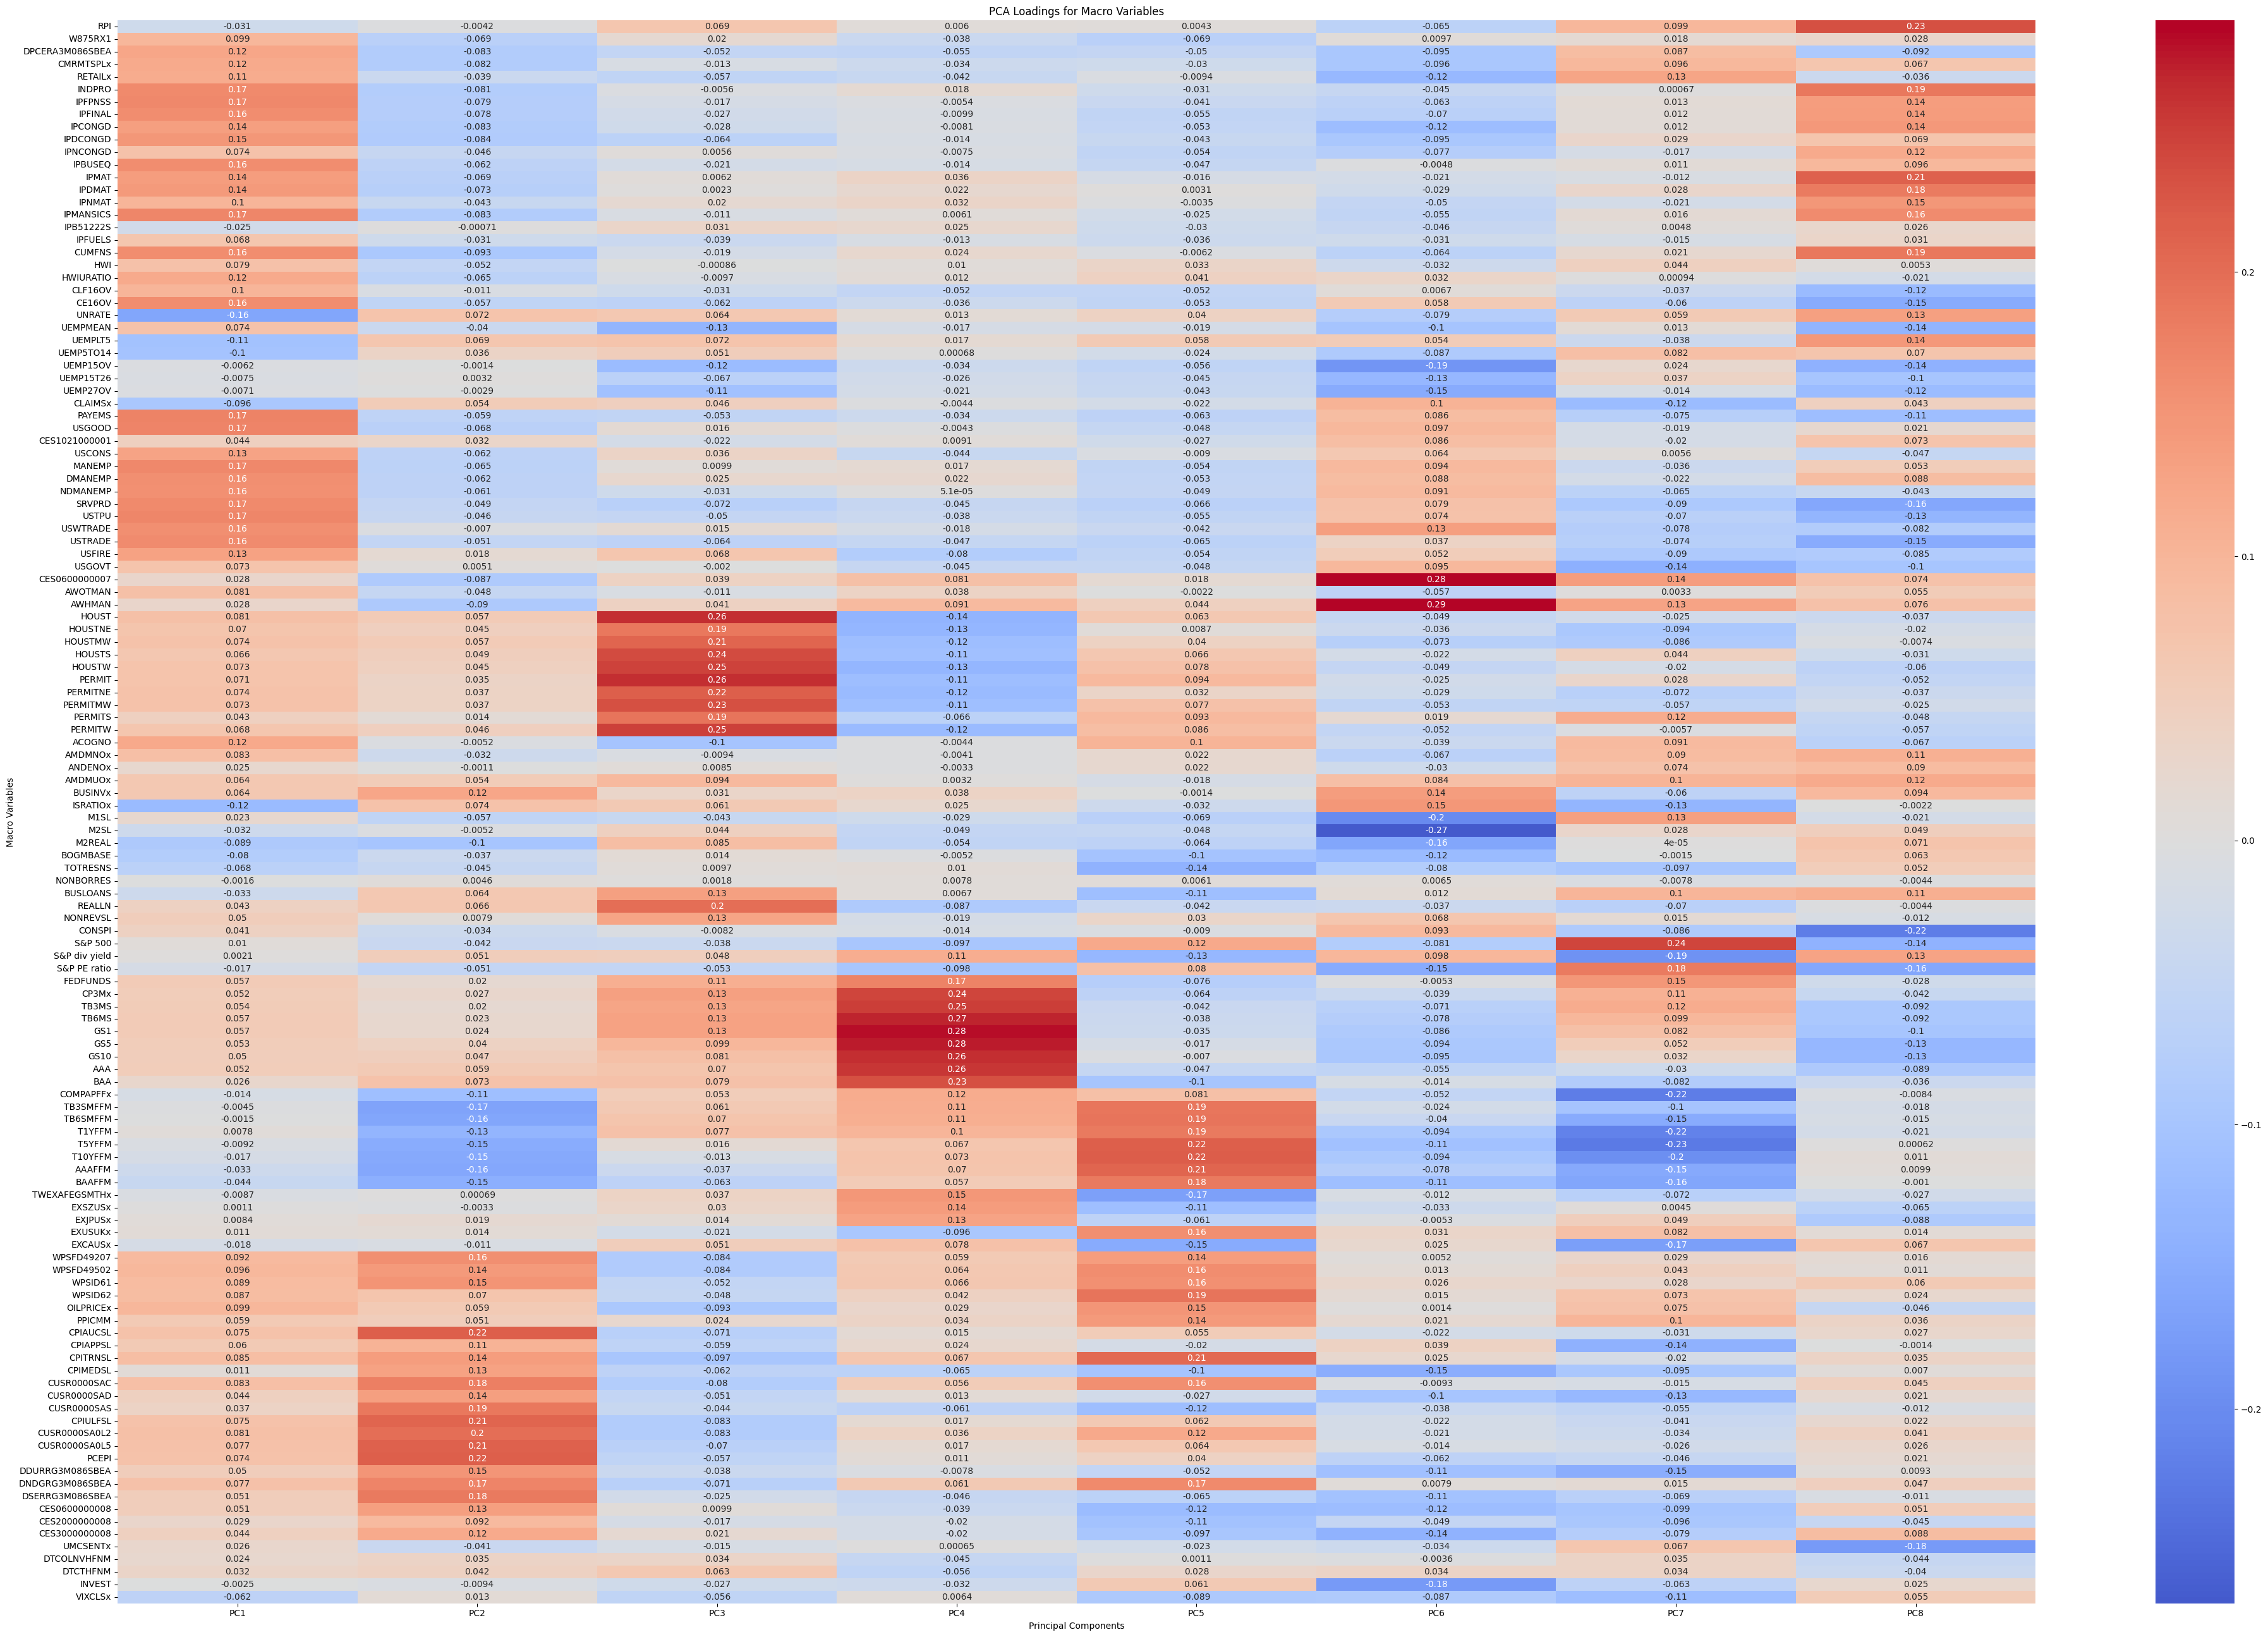

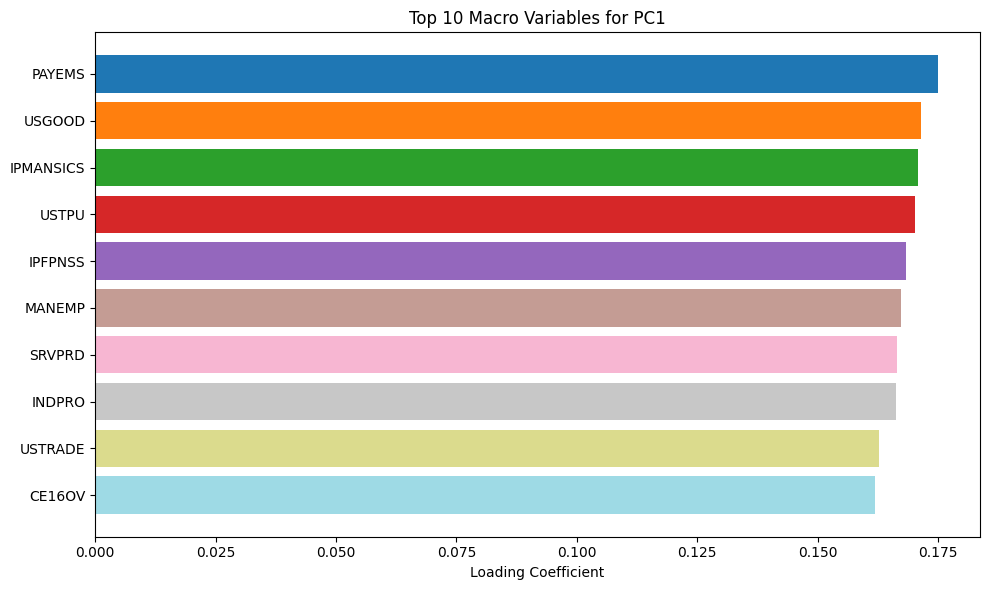

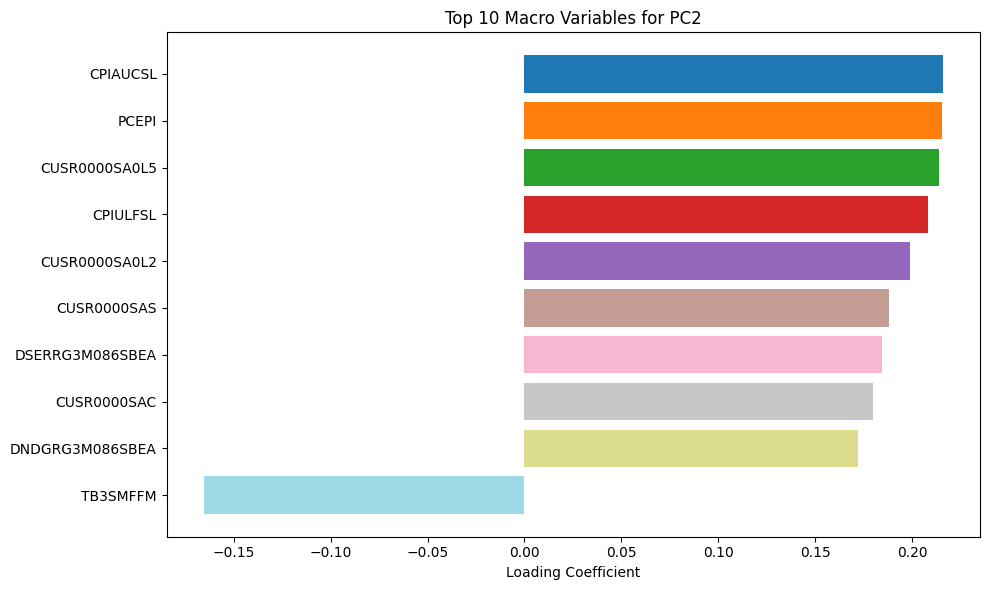

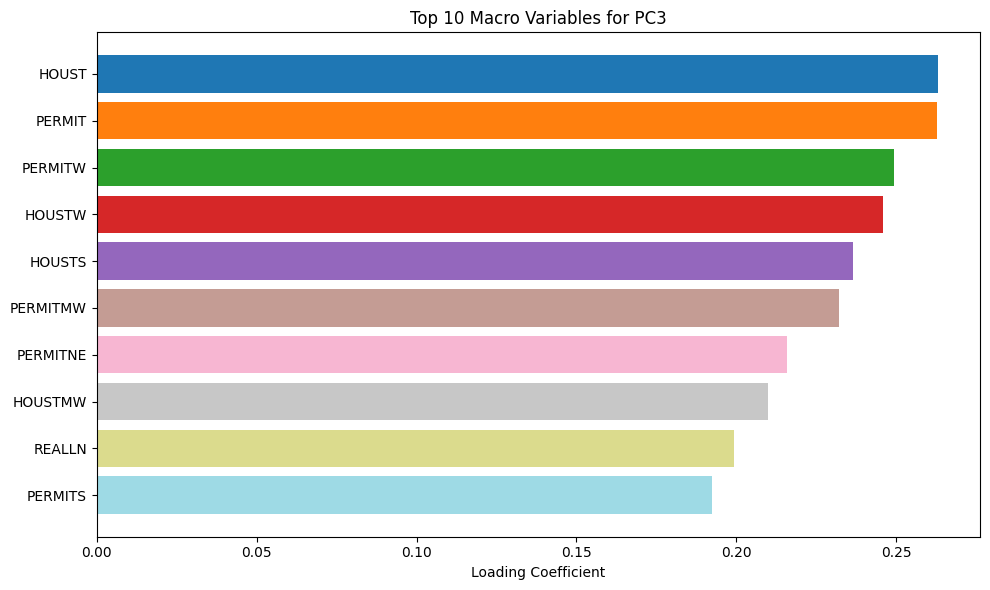

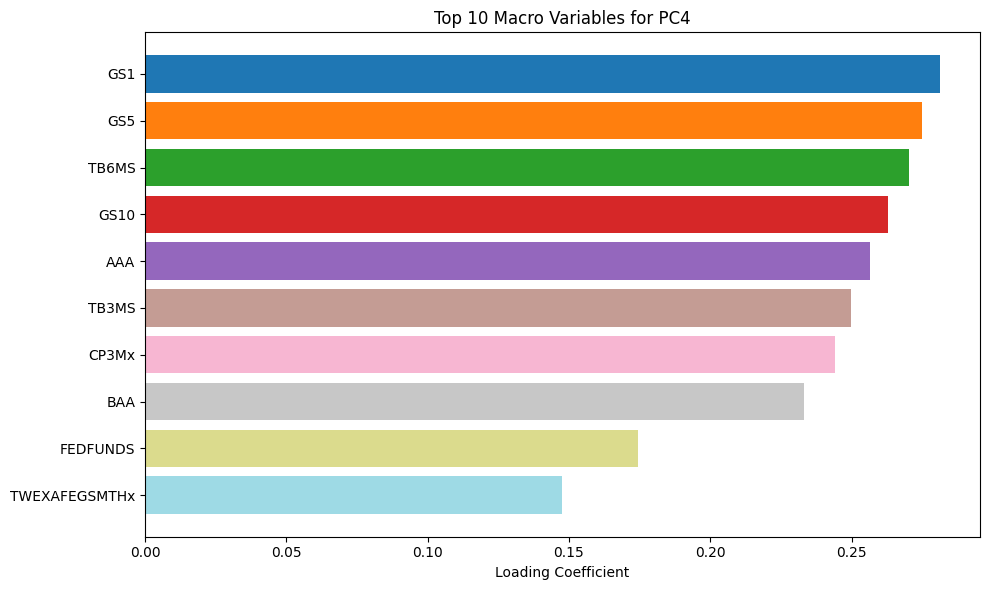

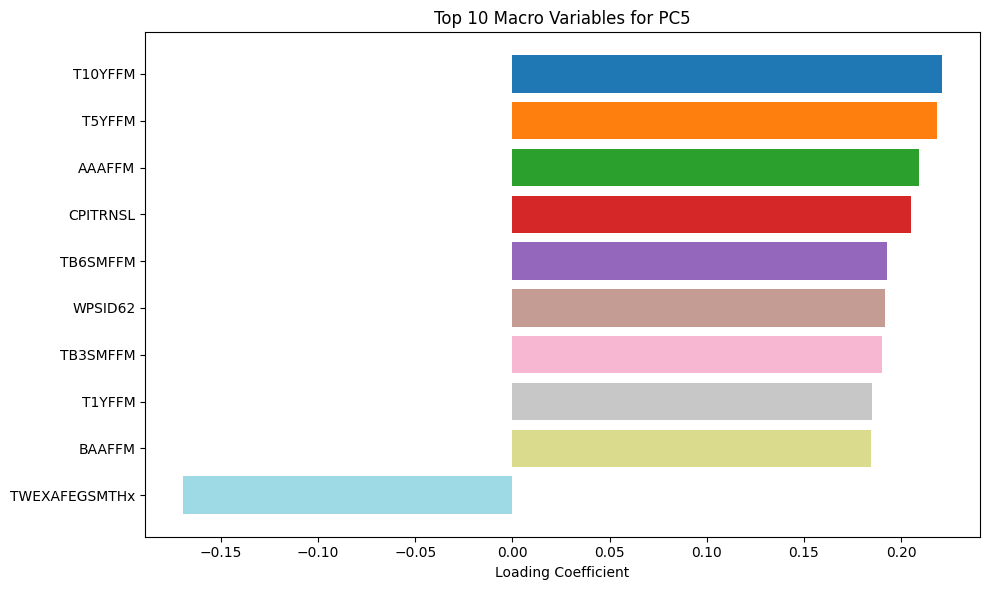

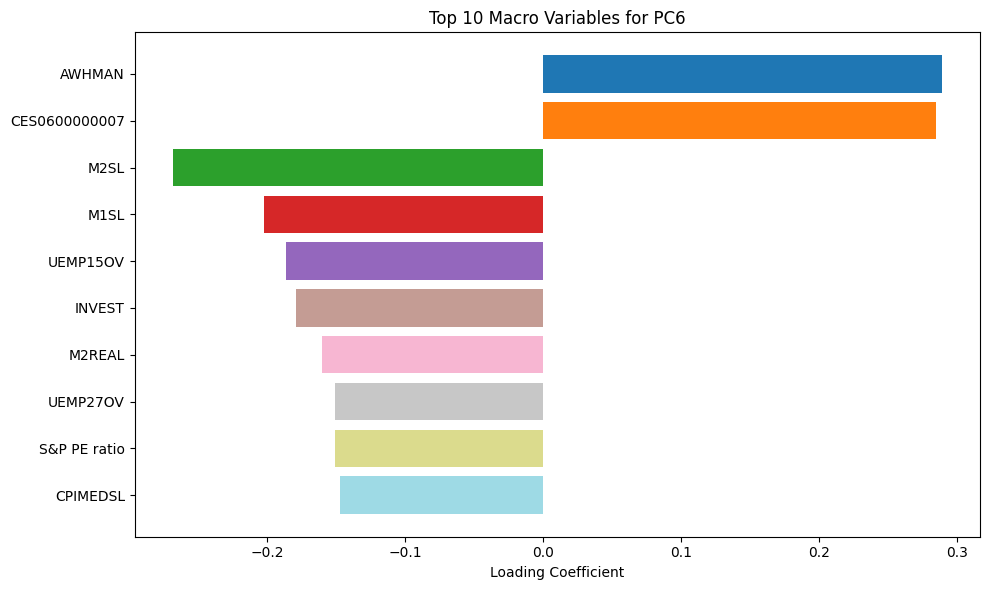

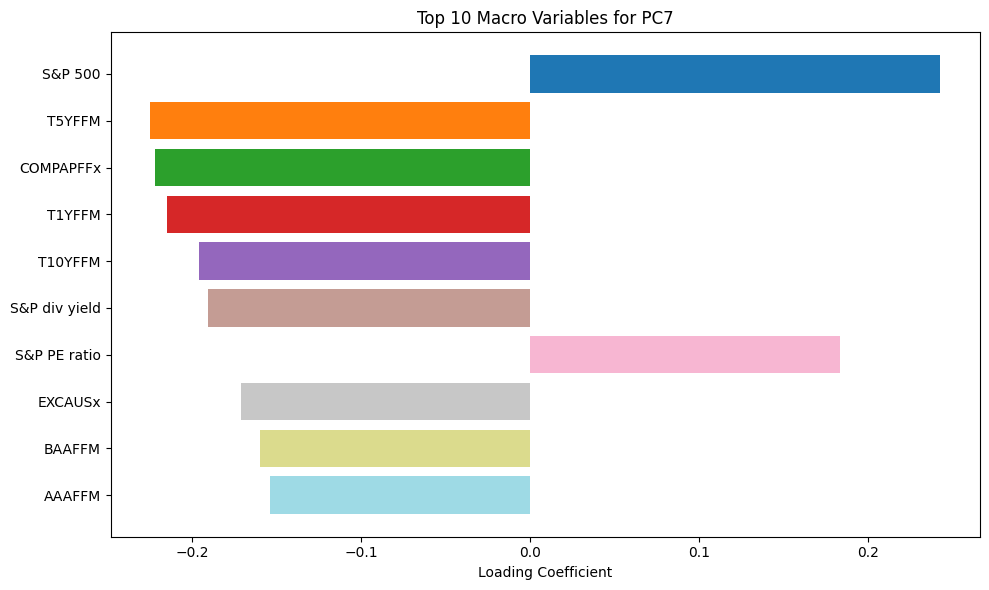

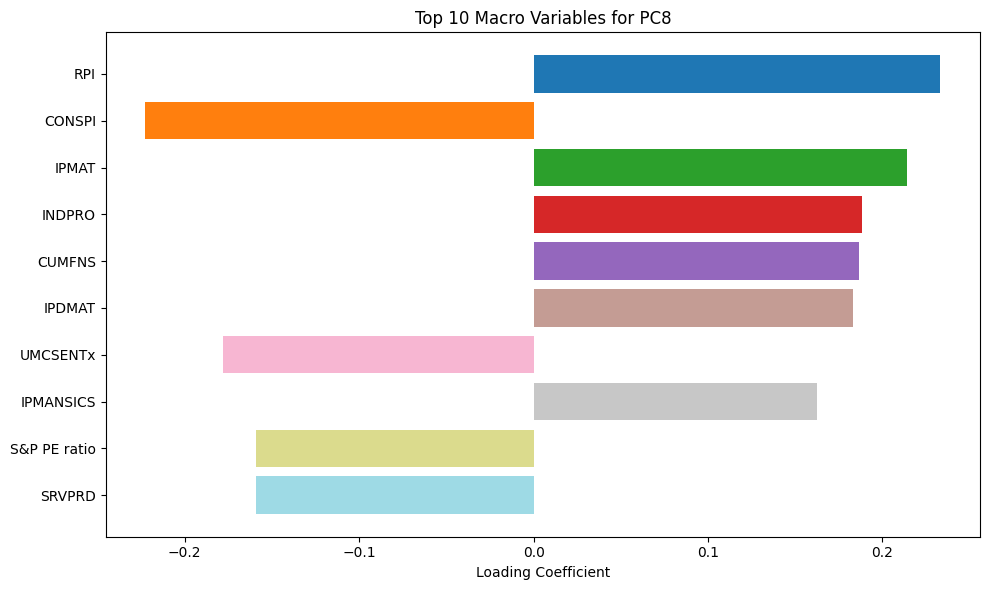

In [34]:
# --- Plot Set 1: Heatmap of PCA Loadings ---
plt.figure(figsize=(40, 26))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings for Macro Variables")
plt.ylabel("Macro Variables")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()

# --- Plot Set 2: Bar Plots for Top 10 Variables per PC ---
top_n = 10  # number of variables to plot per PC
for pc in loadings_df.columns:
    # Sort variables by the absolute value of the loading in descending order
    sorted_loadings = loadings_df[pc].abs().sort_values(ascending=False)
    top_variables = sorted_loadings.index[:top_n]
    # Retrieve the actual loading values for these top variables
    top_loadings = loadings_df.loc[top_variables, pc]
    
    # Use plt.get_cmap() to get a colormap with 'top_n' distinct colors
    cmap = plt.get_cmap("tab20", top_n)
    colors = [cmap(i) for i in range(top_n)]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_loadings)), top_loadings, color=colors)
    plt.yticks(range(len(top_loadings)), top_loadings.index)
    plt.gca().invert_yaxis()  # Highest loading at the top
    plt.title(f"Top {top_n} Macro Variables for {pc}")
    plt.xlabel("Loading Coefficient")
    plt.tight_layout()
    plt.show()



Going through these plots, we can make the following groupings:
- PC1 and PC6 represent labor market variables
- PC2 represents prices related variables and also Money and Credit oriented information; and 
- PC7 seem to represent Interest Rates & Exchange Rates. 

The description of each series and the groups each series belongs to is available in the Appendix of [ McCracken and Ng (2015)](https://s3.amazonaws.com/real.stlouisfed.org/wp/2020/2020-005.pdf)

So, essentially prices and interest rates are the biggest predictors of excess bond returns which is not suprising.  For instance, tight labor markets and rising wages might signal higher inflationary pressures, prompting central banks to adjust policy, which in turn affects bond returns. Similarly, changes in money supply, credit conditions, and exchange rates reflect shifts in liquidity and risk sentiment that are crucial for forecasting future bond performance. Overall, the evidence indicates that incorporating these variables into forecasting models can improve predictions of excess bond returns beyond what is offered by simpler benchmarks.

## Extensions 
You are encouraged to extend this exercise by:
- combining both forward rates and the principal components derived from macroeconomic data into a single forecasting model and then applying all the machine learning methods we’ve covered (penalized regressions, PCR, PLS, and even neural networks). 
- Integrate your forecasting results with the portfolio optimization and asset allocation strategies from our second lab to evaluate whether these improved forecasts translate into enhanced investor performance, see section 5 In Bianchi et al. 
- Additionally, consider exploring neural network approaches. 